In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import pandas as pd
from scipy import signal
import pickle
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
import random
import tensorflow as tf
import cv2
from scipy import stats



# Read Depth Camera

In [2]:
# For reading depth camera
def read_depth_camera(dcamera_path, show_video, nw_resize=1, nh_resize=1):
    video  = cv2.VideoCapture(dcamera_path)
    ret, frame = video.read()
    
    # Get total # of frame count 
    frame_count = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
        
    frame_height = int(frame.shape[0])
    frame_width = int(frame.shape[1])

    
    depth_frames = np.empty((frame_count, int(frame_height/nh_resize), int(frame_width/nw_resize)))
    depth_frames = np.empty((frame_count, int(frame_height/nh_resize), int(frame_width/nw_resize),3))
    count = 0
    while (video.isOpened()):
        ret, frame = video.read()
        
        if ret == True:
#             gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            gray_frame = frame/np.maximum(np.max(frame),255)
            gray_frame = cv2.resize(gray_frame, \
                                    (int(frame_width/nw_resize), int(frame_height/nh_resize)),\
                                    interpolation = cv2.INTER_NEAREST)

            depth_frames[count] = gray_frame
            if show_video == True:
                cv2.imshow("Depth", gray_frame)
                if cv2.waitKey(1) & 0xFF == ord('q'):
                    break
            count = count + 1
        else: 
            break
            

    video.release()
    #cv2.destroyAllWindows()
    return depth_frames

In [3]:
def play_video(read_frames):

    for i in range(len(read_frames)):
        # Capture frame-by-frame
        frame = read_frames[i]

        # Display the resulting frame
        plt.imshow(frame)
#         if cv2.waitKey(1) & 0xFF == ord('q'):
#             break
    #cv2.destroyAllWindows()

    return

In [4]:
def show_frame(read_frames, frame_range):
      # Capture frame-by-frame

    # Display the resulting frame
    for i in frame_range:
        fig = plt.figure(figsize=(6,6))        
        a = plt.imshow(read_frames[i])
        
    return

In [5]:
#fix this to concatenate everything
# n_test = 24
# date = '11_15_2020'
# test_str = '/test' + str(n_test)
# #data_dir = r"C:\Users\77bis\Box\CS598 - Final Project\Preliminary Data V4\Test_Subject_Leo" + test_str
# data_dir = "/home/asilador/CS598/CS598-FinalProject/Preliminary Data V4/Test_Subject_Leo" + test_str
# train_dcamera_path = data_dir + '/depth_processed_leo_test'+str(n_test)+'.avi'
# show_video = 0
# n_resize = 1
# x_train = read_depth_camera(train_dcamera_path, show_video, nw_resize=2, nh_resize=3)


n_test = (24,25)
nw_resize = 2
nh_resize = 3
xtemp = {}
show_video = 0
for i in range(len(n_test)):
    test_str = '/test' + str(n_test[i])
    data_dir = "/home/asilador/CS598/CS598-FinalProject/Preliminary Data V5/Test_Subject_Leo" + test_str
    train_dcamera_path = data_dir + '/depth_processed_leo_test'+str(n_test[i])+'.avi'
    x_train = read_depth_camera(train_dcamera_path, show_video, nw_resize=nw_resize, nh_resize=nh_resize)
    xtemp[i]=x_train

In [6]:
x_train.shape

(14668, 40, 80, 3)

In [7]:
tlen = len(xtemp[0])-2 +len(xtemp[1])-2 #remove 2 samples from 24
x_train = np.zeros((tlen,xtemp[0].shape[1],xtemp[0].shape[2],xtemp[0].shape[3]))
x_train[:len(xtemp[0])-2,:,:,:] = xtemp[0][:len(xtemp[0])-2,:,:,:]
x_train[(len(xtemp[0])-2):,:,:,:] = xtemp[1][:len(xtemp[1])-2,:,:,:]

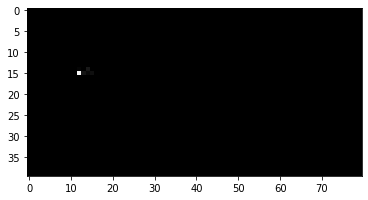

In [8]:
plt.imshow(x_train[-2])


## model.summary()

# read fdss data

In [9]:
#### Removed due to possible syncing/noise issue
# n_test = 24
# date = '11_15_2020'
# test_str = 'test' + str(n_test)
# #data_dir = r"C:\Users\77bis\Box\CS598 - Final Project\Preliminary Data V4\Test_Subject_Leo" + test_str
# data_dir = "/home/asilador/CS598/CS598-FinalProject/Preliminary Data V4/Test_Subject_Leo" + "/" + test_str + "/fcss_processed_leo_" + test_str + "_" + date + ".txt"
# tmpdata = pd.read_csv(data_dir)

In [10]:
# tmpdata.head()

# Read Output Data


In [11]:
def read_output_data(qtm_file_data, theta):
    if theta=='x':
        qtm_data = pd.read_csv(qtm_file_data, usecols = ["Lean Left/Right Angle (deg)"])
    if theta=='y':
        qtm_data = pd.read_csv(qtm_file_data, usecols = ["Lean Forward/Backwards Angle (deg)"])
    if theta=='z':
        qtm_data = pd.read_csv(qtm_file_data, usecols = ["Torso Twist Angle (deg)"])
        
    
    return qtm_data


In [12]:
# n_test = 24
# date = '11_15_2020'
# test_str = '/test' + str(n_test)
# # data_dir = r"C:\Users\77bis\Box\CS598 - Final Project\Preliminary Data V4\Test_Subject_Leo" + test_str
# data_dir = "/home/asilador/CS598/CS598-FinalProject/Preliminary Data V4/Test_Subject_Leo" + test_str
# qtm_file_data_dir = data_dir + '/qtm_processed_leo_test' + str(n_test) + '_' + date + '.txt'
# #show_qtm_plot = True

# y_gt = read_output_data(qtm_file_data_dir,theta_interest).values
# theta_x = read_output_data(qtm_file_data_dir,'x').values
# theta_y = read_output_data(qtm_file_data_dir,'y').values
# theta_z = read_output_data(qtm_file_data_dir,'z').values

n_test = (24,25)
date = ('11_15_2020','11_19_2020')
y_gt = {}
theta_interest = 'z'
for i in range(len(n_test)):
    test_str = '/test' + str(n_test[i])
    data_dir = "/home/asilador/CS598/CS598-FinalProject/Preliminary Data V5/Test_Subject_Leo" + test_str
    qtm_file_data_dir = data_dir + '/qtm_processed_leo_test' + str(n_test[i]) + '_' + date[i] + '.txt'
    y_gttemp = read_output_data(qtm_file_data_dir,theta_interest).values
    y_gt[i]=y_gttemp
    
tlen = len(y_gt[0])-2 +len(y_gt[1])-3 #remove 2 samples from 24 and 3 from 25
y_train = np.zeros((tlen,1))
y_train[:len(y_gt[0])-2] = y_gt[0][:len(y_gt[0])-2]
y_train[(len(y_gt[0])-2):] = y_gt[1][:len(y_gt[1])-3]

In [13]:
y_gt[0].shape

(12751, 1)

In [14]:
# Obtain X and Y data
# x_train.shape
# xtrainnew = pd.DataFrame(data=np.reshape(x_train, (x_train.shape[0],x_train.shape[1]*x_train.shape[2])))
# yframe = pd.DataFrame(data=y_train)

# TheData = pd.concat([xtrainnew,yframe],axis=1) #only contains video data
print(x_train.shape)
print(y_train.shape)

(27415, 40, 80, 3)
(27415, 1)


In [15]:
print(xtemp[0].shape)
print(y_gt[0].shape)
print(xtemp[1].shape)
print(y_gt[1].shape)

(12751, 40, 80, 3)
(12751, 1)
(14668, 40, 80, 3)
(14669, 1)


In [16]:
# xtmp = xtrainnew[300,:]
# plt.imshow(np.reshape(xtmp, (x_train.shape[1],x_train.shape[2])))

In [17]:
nsamps = x_train.shape[0]
n80p = int(np.floor(nsamps*0.8))
rannums = np.array(random.sample(range(1,nsamps,1), n80p))
s_nfiles = np.arange(nsamps)
test_set = np.setdiff1d(s_nfiles,rannums)

#

In [18]:
Trainset = x_train[rannums,:]
Testset = x_train[test_set,:]
# Trainy= y_gt[rannums,:]
# Testy = y_gt[test_set,:]
Trainy= y_train[rannums,:]
Testy = y_train[test_set,:]

In [19]:
sc_y = StandardScaler()

In [20]:
Xtrainz = Trainset
ytrainz = Trainy
X = Xtrainz
y = sc_y.fit_transform(ytrainz)

In [21]:
#make validation data available to model.fit
Xvalid = Testset

y_valid = Testy
y_valid = sc_y.transform(y_valid)


In [22]:
x_train.shape[1]

40

# Regress using Neural Network

In [23]:
np.min(Xvalid) #7min*30fps*60s/min*0.8 ~ 10800

0.0

In [24]:
# Create Neural Netowrk
# model = tf.keras.Sequential()
# model.add(tf.keras.Input(shape=(X.shape[1],)))
# model.add(tf.keras.layers.Dense(200, activation="relu"))
# #model.add(tf.keras.layers.Dropout(0.5))
# model.add(tf.keras.layers.Dense(200, activation="relu"))
# model.add(tf.keras.layers.Dropout(0.5))          
# model.add(tf.keras.layers.Dense(100, activation='linear')) #added extra layer. probably overkill but want good results
# model.add(tf.keras.layers.Dense(1, activation='linear'))
# model.compile(optimizer='adam',
#               loss='mae',
#               metrics=['mse','mae'])
    
# # loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

# # loss_fn(y_train[:1], predictions).numpy()

from keras.layers import Bidirectional, Conv2D, MaxPooling2D, Input, Concatenate
from keras.layers.normalization import BatchNormalization
from keras.layers.core import Dense, Activation, Dropout, Reshape, Permute, Flatten
from keras.models import Model
batch_sz = 32
model_start = Input(shape=(x_train.shape[1],x_train.shape[2],x_train.shape[3]))
model_cnn = model_start
# f_pool_size = (5,2,2)
dropout_rate = 0.5
# for i, convCnt in enumerate(f_pool_size):
#     model_cnn = Conv2D(filters=x_train.shape[2], kernel_size=(3, 3))(model_cnn)
#     model_cnn = BatchNormalization()(model_cnn)
#     model_cnn = Activation('relu')(model_cnn)
#     model_cnn = MaxPooling2D(pool_size=(f_pool_size[i], f_pool_size[i]))(model_cnn)
#     model_cnn = Dropout(dropout_rate)(model_cnn)

model_cnn = Conv2D(filters=64, kernel_size=(3, 3))(model_cnn)
# model_cnn = BatchNormalization()(model_cnn)
model_cnn = Activation('relu')(model_cnn)
model_cnn = MaxPooling2D(pool_size=(5, 5))(model_cnn)
model_cnn = Dropout(dropout_rate)(model_cnn)

model_cnn = Conv2D(filters=64, kernel_size=(3, 3))(model_cnn)
# model_cnn = BatchNormalization()(model_cnn)
model_cnn = Activation('relu')(model_cnn)
model_cnn = MaxPooling2D(pool_size=(1, 1))(model_cnn)
model_cnn = Dropout(dropout_rate)(model_cnn)

model_cnn = Conv2D(filters=64, kernel_size=(3, 3))(model_cnn)
# model_cnn = BatchNormalization()(model_cnn)
model_cnn = Activation('relu')(model_cnn)
model_cnn = MaxPooling2D(pool_size=(1, 1))(model_cnn)
model_cnn = Dropout(dropout_rate)(model_cnn)


model_cnn = Flatten()(model_cnn)
model_cnn = Activation('relu')(model_cnn)
# model_cnn = Dropout(dropout_rate)(model_cnn)

model_cnn = Dense(128)(model_cnn)
model_cnn = Activation('relu')(model_cnn)
# model_cnn = Dropout(dropout_rate)(model_cnn)

# model_cnn = Dense(200)(model_cnn)
# model_cnn = Activation('relu')(model_cnn)
# model_cnn = Dropout(dropout_rate)(model_cnn)

output = Dense(1)(model_cnn)
output = Activation('linear', name='thetaz_out')(output)
model = Model(inputs=model_start,outputs=output)
model.compile(optimizer='adam',
              loss='mae',
              metrics=['mse','mae'])


callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50,restore_best_weights=True) #Moving to 1000 patience. 
model.summary()

Using TensorFlow backend.


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 40, 80, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 38, 78, 64)        1792      
_________________________________________________________________
activation_1 (Activation)    (None, 38, 78, 64)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 15, 64)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 15, 64)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 5, 13, 64)         36928     
_________________________________________________________________
activation_2 (Activation)    (None, 5, 13, 64)         0   

In [25]:
epochs = int(30000)
batch_size = 256
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50,restore_best_weights=True)
history = model.fit(X, y,batch_size=batch_size, epochs = epochs,callbacks = [callback],validation_data = (Xvalid, y_valid),verbose=2)

# model.save('depthforcemodel.h5')
#history.save('depthforcehist.h5')

Train on 21932 samples, validate on 5483 samples
Epoch 1/30000
 - 4s - loss: 0.6839 - mse: 0.9785 - mae: 0.6839 - val_loss: 0.6646 - val_mse: 0.9620 - val_mae: 0.6646
Epoch 2/30000
 - 3s - loss: 0.6694 - mse: 0.9526 - mae: 0.6694 - val_loss: 0.6532 - val_mse: 0.9416 - val_mae: 0.6532
Epoch 3/30000
 - 3s - loss: 0.6632 - mse: 0.9380 - mae: 0.6632 - val_loss: 0.6494 - val_mse: 0.9368 - val_mae: 0.6494
Epoch 4/30000
 - 3s - loss: 0.6584 - mse: 0.9281 - mae: 0.6584 - val_loss: 0.6395 - val_mse: 0.9069 - val_mae: 0.6395
Epoch 5/30000
 - 3s - loss: 0.6515 - mse: 0.9085 - mae: 0.6515 - val_loss: 0.6361 - val_mse: 0.8963 - val_mae: 0.6361
Epoch 6/30000
 - 3s - loss: 0.6442 - mse: 0.8927 - mae: 0.6442 - val_loss: 0.6261 - val_mse: 0.8720 - val_mae: 0.6261
Epoch 7/30000
 - 3s - loss: 0.6402 - mse: 0.8821 - mae: 0.6402 - val_loss: 0.6156 - val_mse: 0.8550 - val_mae: 0.6156
Epoch 8/30000
 - 3s - loss: 0.6347 - mse: 0.8662 - mae: 0.6347 - val_loss: 0.6152 - val_mse: 0.8515 - val_mae: 0.6152
Epoch 9

Epoch 70/30000
 - 3s - loss: 0.4716 - mse: 0.5262 - mae: 0.4716 - val_loss: 0.4675 - val_mse: 0.5559 - val_mae: 0.4675
Epoch 71/30000
 - 3s - loss: 0.4697 - mse: 0.5228 - mae: 0.4697 - val_loss: 0.4649 - val_mse: 0.5489 - val_mae: 0.4649
Epoch 72/30000
 - 3s - loss: 0.4671 - mse: 0.5185 - mae: 0.4671 - val_loss: 0.4645 - val_mse: 0.5525 - val_mae: 0.4645
Epoch 73/30000
 - 3s - loss: 0.4645 - mse: 0.5111 - mae: 0.4645 - val_loss: 0.4627 - val_mse: 0.5502 - val_mae: 0.4627
Epoch 74/30000
 - 3s - loss: 0.4653 - mse: 0.5179 - mae: 0.4653 - val_loss: 0.4623 - val_mse: 0.5499 - val_mae: 0.4623
Epoch 75/30000
 - 3s - loss: 0.4663 - mse: 0.5159 - mae: 0.4663 - val_loss: 0.4639 - val_mse: 0.5509 - val_mae: 0.4639
Epoch 76/30000
 - 3s - loss: 0.4679 - mse: 0.5215 - mae: 0.4679 - val_loss: 0.4613 - val_mse: 0.5484 - val_mae: 0.4613
Epoch 77/30000
 - 3s - loss: 0.4633 - mse: 0.5086 - mae: 0.4633 - val_loss: 0.4617 - val_mse: 0.5466 - val_mae: 0.4617
Epoch 78/30000
 - 3s - loss: 0.4638 - mse: 0.509

Epoch 139/30000
 - 3s - loss: 0.4216 - mse: 0.4361 - mae: 0.4216 - val_loss: 0.4307 - val_mse: 0.4920 - val_mae: 0.4307
Epoch 140/30000
 - 3s - loss: 0.4199 - mse: 0.4282 - mae: 0.4199 - val_loss: 0.4312 - val_mse: 0.4991 - val_mae: 0.4312
Epoch 141/30000
 - 3s - loss: 0.4196 - mse: 0.4292 - mae: 0.4196 - val_loss: 0.4302 - val_mse: 0.4980 - val_mae: 0.4302
Epoch 142/30000
 - 3s - loss: 0.4165 - mse: 0.4238 - mae: 0.4165 - val_loss: 0.4294 - val_mse: 0.4972 - val_mae: 0.4294
Epoch 143/30000
 - 3s - loss: 0.4169 - mse: 0.4233 - mae: 0.4169 - val_loss: 0.4308 - val_mse: 0.4965 - val_mae: 0.4308
Epoch 144/30000
 - 3s - loss: 0.4170 - mse: 0.4236 - mae: 0.4170 - val_loss: 0.4317 - val_mse: 0.4977 - val_mae: 0.4317
Epoch 145/30000
 - 3s - loss: 0.4174 - mse: 0.4223 - mae: 0.4174 - val_loss: 0.4313 - val_mse: 0.4976 - val_mae: 0.4313
Epoch 146/30000
 - 3s - loss: 0.4173 - mse: 0.4255 - mae: 0.4173 - val_loss: 0.4344 - val_mse: 0.5003 - val_mae: 0.4344
Epoch 147/30000
 - 3s - loss: 0.4157 - m

Epoch 208/30000
 - 3s - loss: 0.3944 - mse: 0.3819 - mae: 0.3944 - val_loss: 0.4138 - val_mse: 0.4680 - val_mae: 0.4138
Epoch 209/30000
 - 3s - loss: 0.3907 - mse: 0.3790 - mae: 0.3907 - val_loss: 0.4144 - val_mse: 0.4653 - val_mae: 0.4144
Epoch 210/30000
 - 3s - loss: 0.3969 - mse: 0.3872 - mae: 0.3969 - val_loss: 0.4117 - val_mse: 0.4637 - val_mae: 0.4117
Epoch 211/30000
 - 3s - loss: 0.3916 - mse: 0.3793 - mae: 0.3916 - val_loss: 0.4127 - val_mse: 0.4671 - val_mae: 0.4127
Epoch 212/30000
 - 3s - loss: 0.3932 - mse: 0.3828 - mae: 0.3932 - val_loss: 0.4127 - val_mse: 0.4643 - val_mae: 0.4127
Epoch 213/30000
 - 3s - loss: 0.3936 - mse: 0.3817 - mae: 0.3936 - val_loss: 0.4144 - val_mse: 0.4679 - val_mae: 0.4144
Epoch 214/30000
 - 3s - loss: 0.3893 - mse: 0.3732 - mae: 0.3893 - val_loss: 0.4129 - val_mse: 0.4663 - val_mae: 0.4129
Epoch 215/30000
 - 3s - loss: 0.3891 - mse: 0.3735 - mae: 0.3891 - val_loss: 0.4115 - val_mse: 0.4656 - val_mae: 0.4115
Epoch 216/30000
 - 3s - loss: 0.3881 - m

Epoch 277/30000
 - 3s - loss: 0.3750 - mse: 0.3483 - mae: 0.3750 - val_loss: 0.4038 - val_mse: 0.4542 - val_mae: 0.4038
Epoch 278/30000
 - 3s - loss: 0.3765 - mse: 0.3487 - mae: 0.3765 - val_loss: 0.4025 - val_mse: 0.4537 - val_mae: 0.4025
Epoch 279/30000
 - 3s - loss: 0.3758 - mse: 0.3493 - mae: 0.3758 - val_loss: 0.4065 - val_mse: 0.4555 - val_mae: 0.4065
Epoch 280/30000
 - 3s - loss: 0.3746 - mse: 0.3486 - mae: 0.3746 - val_loss: 0.4052 - val_mse: 0.4572 - val_mae: 0.4052
Epoch 281/30000
 - 3s - loss: 0.3767 - mse: 0.3523 - mae: 0.3767 - val_loss: 0.4050 - val_mse: 0.4524 - val_mae: 0.4050
Epoch 282/30000
 - 3s - loss: 0.3767 - mse: 0.3546 - mae: 0.3767 - val_loss: 0.4026 - val_mse: 0.4520 - val_mae: 0.4026
Epoch 283/30000
 - 3s - loss: 0.3766 - mse: 0.3537 - mae: 0.3766 - val_loss: 0.4064 - val_mse: 0.4612 - val_mae: 0.4064
Epoch 284/30000
 - 3s - loss: 0.3720 - mse: 0.3461 - mae: 0.3720 - val_loss: 0.4064 - val_mse: 0.4595 - val_mae: 0.4064
Epoch 285/30000
 - 3s - loss: 0.3725 - m

Epoch 346/30000
 - 3s - loss: 0.3662 - mse: 0.3298 - mae: 0.3662 - val_loss: 0.3965 - val_mse: 0.4394 - val_mae: 0.3965
Epoch 347/30000
 - 3s - loss: 0.3657 - mse: 0.3357 - mae: 0.3657 - val_loss: 0.3951 - val_mse: 0.4346 - val_mae: 0.3951
Epoch 348/30000
 - 3s - loss: 0.3637 - mse: 0.3270 - mae: 0.3637 - val_loss: 0.3964 - val_mse: 0.4387 - val_mae: 0.3964
Epoch 349/30000
 - 3s - loss: 0.3648 - mse: 0.3327 - mae: 0.3648 - val_loss: 0.3978 - val_mse: 0.4387 - val_mae: 0.3978
Epoch 350/30000
 - 3s - loss: 0.3664 - mse: 0.3309 - mae: 0.3664 - val_loss: 0.3965 - val_mse: 0.4371 - val_mae: 0.3965
Epoch 351/30000
 - 3s - loss: 0.3621 - mse: 0.3328 - mae: 0.3621 - val_loss: 0.3965 - val_mse: 0.4395 - val_mae: 0.3965
Epoch 352/30000
 - 3s - loss: 0.3642 - mse: 0.3286 - mae: 0.3642 - val_loss: 0.3989 - val_mse: 0.4424 - val_mae: 0.3989
Epoch 353/30000
 - 3s - loss: 0.3640 - mse: 0.3301 - mae: 0.3640 - val_loss: 0.3952 - val_mse: 0.4383 - val_mae: 0.3952
Epoch 354/30000
 - 3s - loss: 0.3637 - m

Epoch 415/30000
 - 3s - loss: 0.3537 - mse: 0.3129 - mae: 0.3537 - val_loss: 0.3957 - val_mse: 0.4360 - val_mae: 0.3957
Epoch 416/30000
 - 3s - loss: 0.3555 - mse: 0.3159 - mae: 0.3555 - val_loss: 0.3956 - val_mse: 0.4378 - val_mae: 0.3956
Epoch 417/30000
 - 3s - loss: 0.3525 - mse: 0.3090 - mae: 0.3525 - val_loss: 0.3933 - val_mse: 0.4353 - val_mae: 0.3933
Epoch 418/30000
 - 3s - loss: 0.3563 - mse: 0.3182 - mae: 0.3563 - val_loss: 0.3948 - val_mse: 0.4357 - val_mae: 0.3948
Epoch 419/30000
 - 3s - loss: 0.3539 - mse: 0.3125 - mae: 0.3539 - val_loss: 0.3931 - val_mse: 0.4343 - val_mae: 0.3931
Epoch 420/30000
 - 3s - loss: 0.3541 - mse: 0.3160 - mae: 0.3541 - val_loss: 0.3960 - val_mse: 0.4368 - val_mae: 0.3960
Epoch 421/30000
 - 3s - loss: 0.3570 - mse: 0.3151 - mae: 0.3570 - val_loss: 0.3930 - val_mse: 0.4361 - val_mae: 0.3930
Epoch 422/30000
 - 3s - loss: 0.3588 - mse: 0.3175 - mae: 0.3588 - val_loss: 0.3931 - val_mse: 0.4319 - val_mae: 0.3931
Epoch 423/30000
 - 3s - loss: 0.3564 - m

Epoch 484/30000
 - 3s - loss: 0.3490 - mse: 0.3045 - mae: 0.3490 - val_loss: 0.3913 - val_mse: 0.4304 - val_mae: 0.3913
Epoch 485/30000
 - 3s - loss: 0.3521 - mse: 0.3092 - mae: 0.3521 - val_loss: 0.3881 - val_mse: 0.4255 - val_mae: 0.3881
Epoch 486/30000
 - 3s - loss: 0.3506 - mse: 0.3060 - mae: 0.3506 - val_loss: 0.3917 - val_mse: 0.4361 - val_mae: 0.3917
Epoch 487/30000
 - 3s - loss: 0.3512 - mse: 0.3083 - mae: 0.3512 - val_loss: 0.3925 - val_mse: 0.4341 - val_mae: 0.3925
Epoch 488/30000
 - 3s - loss: 0.3493 - mse: 0.3005 - mae: 0.3493 - val_loss: 0.3913 - val_mse: 0.4320 - val_mae: 0.3913
Epoch 489/30000
 - 3s - loss: 0.3488 - mse: 0.3030 - mae: 0.3488 - val_loss: 0.3897 - val_mse: 0.4276 - val_mae: 0.3897
Epoch 490/30000
 - 3s - loss: 0.3473 - mse: 0.2997 - mae: 0.3473 - val_loss: 0.3886 - val_mse: 0.4280 - val_mae: 0.3886
Epoch 491/30000
 - 3s - loss: 0.3483 - mse: 0.3031 - mae: 0.3483 - val_loss: 0.3907 - val_mse: 0.4308 - val_mae: 0.3907
Epoch 492/30000
 - 3s - loss: 0.3485 - m

Epoch 553/30000
 - 3s - loss: 0.3431 - mse: 0.2932 - mae: 0.3431 - val_loss: 0.3884 - val_mse: 0.4275 - val_mae: 0.3884
Epoch 554/30000
 - 3s - loss: 0.3423 - mse: 0.2942 - mae: 0.3423 - val_loss: 0.3887 - val_mse: 0.4283 - val_mae: 0.3887
Epoch 555/30000
 - 3s - loss: 0.3436 - mse: 0.2945 - mae: 0.3436 - val_loss: 0.3884 - val_mse: 0.4260 - val_mae: 0.3884
Epoch 556/30000
 - 3s - loss: 0.3467 - mse: 0.2987 - mae: 0.3467 - val_loss: 0.3887 - val_mse: 0.4301 - val_mae: 0.3887
Epoch 557/30000
 - 3s - loss: 0.3440 - mse: 0.2943 - mae: 0.3440 - val_loss: 0.3901 - val_mse: 0.4335 - val_mae: 0.3901
Epoch 558/30000
 - 3s - loss: 0.3420 - mse: 0.2959 - mae: 0.3420 - val_loss: 0.3905 - val_mse: 0.4348 - val_mae: 0.3905
Epoch 559/30000
 - 3s - loss: 0.3438 - mse: 0.2935 - mae: 0.3438 - val_loss: 0.3874 - val_mse: 0.4265 - val_mae: 0.3874
Epoch 560/30000
 - 3s - loss: 0.3401 - mse: 0.2909 - mae: 0.3401 - val_loss: 0.3896 - val_mse: 0.4296 - val_mae: 0.3896
Epoch 561/30000
 - 3s - loss: 0.3423 - m

Epoch 622/30000
 - 3s - loss: 0.3393 - mse: 0.2891 - mae: 0.3393 - val_loss: 0.3861 - val_mse: 0.4237 - val_mae: 0.3861
Epoch 623/30000
 - 3s - loss: 0.3391 - mse: 0.2911 - mae: 0.3391 - val_loss: 0.3866 - val_mse: 0.4236 - val_mae: 0.3866
Epoch 624/30000
 - 3s - loss: 0.3361 - mse: 0.2823 - mae: 0.3361 - val_loss: 0.3863 - val_mse: 0.4228 - val_mae: 0.3863
Epoch 625/30000
 - 3s - loss: 0.3388 - mse: 0.2863 - mae: 0.3388 - val_loss: 0.3886 - val_mse: 0.4297 - val_mae: 0.3886
Epoch 626/30000
 - 3s - loss: 0.3348 - mse: 0.2821 - mae: 0.3348 - val_loss: 0.3860 - val_mse: 0.4221 - val_mae: 0.3860
Epoch 627/30000
 - 3s - loss: 0.3357 - mse: 0.2862 - mae: 0.3357 - val_loss: 0.3874 - val_mse: 0.4269 - val_mae: 0.3874
Epoch 628/30000
 - 3s - loss: 0.3379 - mse: 0.2882 - mae: 0.3379 - val_loss: 0.3896 - val_mse: 0.4289 - val_mae: 0.3896
Epoch 629/30000
 - 3s - loss: 0.3408 - mse: 0.2895 - mae: 0.3408 - val_loss: 0.3868 - val_mse: 0.4200 - val_mae: 0.3868
Epoch 630/30000
 - 3s - loss: 0.3386 - m

Epoch 691/30000
 - 3s - loss: 0.3374 - mse: 0.2870 - mae: 0.3374 - val_loss: 0.3870 - val_mse: 0.4303 - val_mae: 0.3870
Epoch 692/30000
 - 3s - loss: 0.3347 - mse: 0.2824 - mae: 0.3347 - val_loss: 0.3851 - val_mse: 0.4239 - val_mae: 0.3851
Epoch 693/30000
 - 3s - loss: 0.3362 - mse: 0.2839 - mae: 0.3362 - val_loss: 0.3833 - val_mse: 0.4195 - val_mae: 0.3833
Epoch 694/30000
 - 3s - loss: 0.3347 - mse: 0.2828 - mae: 0.3347 - val_loss: 0.3835 - val_mse: 0.4182 - val_mae: 0.3835
Epoch 695/30000
 - 3s - loss: 0.3345 - mse: 0.2818 - mae: 0.3345 - val_loss: 0.3843 - val_mse: 0.4220 - val_mae: 0.3843
Epoch 696/30000
 - 3s - loss: 0.3343 - mse: 0.2824 - mae: 0.3343 - val_loss: 0.3822 - val_mse: 0.4197 - val_mae: 0.3822
Epoch 697/30000
 - 3s - loss: 0.3337 - mse: 0.2816 - mae: 0.3337 - val_loss: 0.3834 - val_mse: 0.4179 - val_mae: 0.3834
Epoch 698/30000
 - 3s - loss: 0.3356 - mse: 0.2827 - mae: 0.3356 - val_loss: 0.3837 - val_mse: 0.4202 - val_mae: 0.3837
Epoch 699/30000
 - 3s - loss: 0.3347 - m

Epoch 760/30000
 - 3s - loss: 0.3317 - mse: 0.2779 - mae: 0.3317 - val_loss: 0.3820 - val_mse: 0.4172 - val_mae: 0.3820
Epoch 761/30000
 - 3s - loss: 0.3325 - mse: 0.2785 - mae: 0.3325 - val_loss: 0.3841 - val_mse: 0.4230 - val_mae: 0.3841
Epoch 762/30000
 - 3s - loss: 0.3324 - mse: 0.2780 - mae: 0.3324 - val_loss: 0.3876 - val_mse: 0.4259 - val_mae: 0.3876
Epoch 763/30000
 - 3s - loss: 0.3326 - mse: 0.2801 - mae: 0.3326 - val_loss: 0.3820 - val_mse: 0.4184 - val_mae: 0.3820
Epoch 764/30000
 - 3s - loss: 0.3307 - mse: 0.2752 - mae: 0.3307 - val_loss: 0.3824 - val_mse: 0.4202 - val_mae: 0.3824
Epoch 765/30000
 - 3s - loss: 0.3315 - mse: 0.2756 - mae: 0.3315 - val_loss: 0.3819 - val_mse: 0.4175 - val_mae: 0.3819
Epoch 766/30000
 - 3s - loss: 0.3341 - mse: 0.2794 - mae: 0.3341 - val_loss: 0.3860 - val_mse: 0.4248 - val_mae: 0.3860
Epoch 767/30000
 - 3s - loss: 0.3314 - mse: 0.2768 - mae: 0.3314 - val_loss: 0.3811 - val_mse: 0.4187 - val_mae: 0.3811
Epoch 768/30000
 - 3s - loss: 0.3329 - m

<function matplotlib.use(backend, *, force=True)>

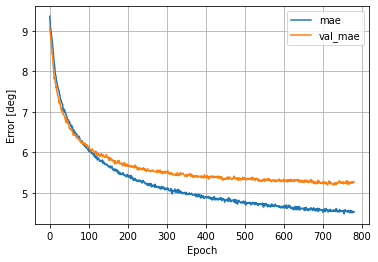

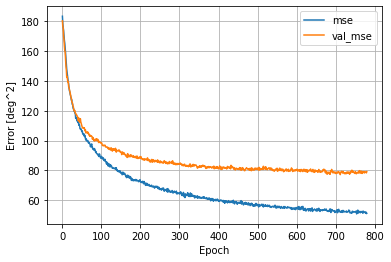

In [26]:
def plot_loss(history):
    
    v1 = history.history['mae']*np.sqrt(sc_y.var_)
    v2 = history.history['val_mae']*np.sqrt(sc_y.var_)
    fig1 = plt.figure()
    ax1 = fig1.add_subplot(111)
    ax1.plot(v1, label='mae')
    ax1.plot(v2, label='val_mae')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Error [deg]')
    ax1.legend()
    ax1.grid(True)
    plt.show()
    
    v3 = history.history['mse']*sc_y.var_
    v4 = history.history['val_mse']*sc_y.var_
    fig2 = plt.figure()
    ax2 = fig2.add_subplot(111)
    ax2.plot(v3, label='mse')
    ax2.plot(v4, label='val_mse')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Error [deg^2]')
    ax2.legend()
    ax2.grid(True)
    plt.show()
    
    
plot_loss(history)


### 4-layer Network: Predict Against Training Data as a Sanity Check

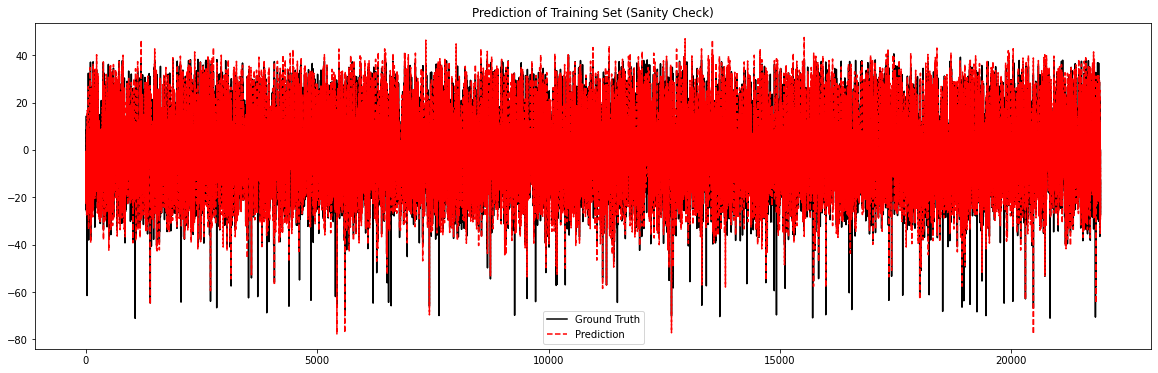

Average error is 0.11 degrees
Root Mean Squared Error is 2.90 degrees
Mean Absolute Error is 2.90 degrees


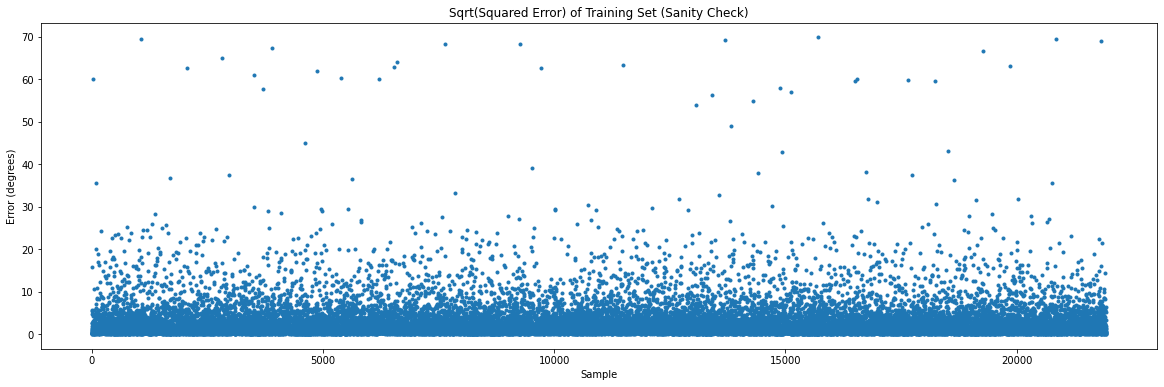

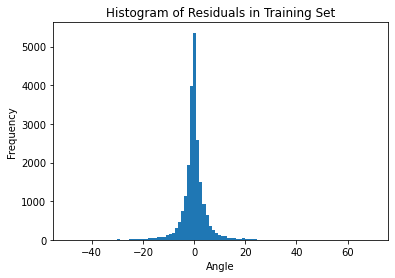

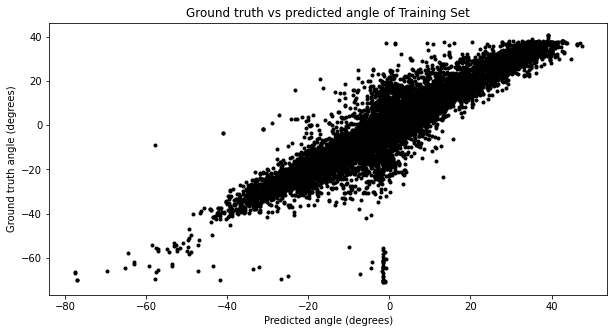

In [27]:

# sanity check with 80% data
Xtrain = Trainset
y_pred = model.predict(Xtrain)
#y_pred = sc_y.inverse_transform(y_pred)
y_pred = sc_y.inverse_transform(y_pred)
y_new = Trainy
plt.figure(figsize=(20,6))
plt.plot(y_new,'k')
plt.plot(y_pred,'r--')
plt.title('Prediction of Training Set (Sanity Check)')
#plt.axis([xmin, xmax, ymin, ymax])
plt.legend(labels=['Ground Truth','Prediction'])
plt.show()
# Squared-root of Squared Error

test_error = (y_pred - y_new)
print('Average error is {:4.2f} degrees'.format(np.sum(test_error)/test_error.shape[0]))
rmse = np.sqrt(test_error**2)
print('Root Mean Squared Error is {:4.2f} degrees'.format(np.sum(rmse)/test_error.shape[0]))
# Mean absolute error
print('Mean Absolute Error is {:4.2f} degrees'.format(np.sum(np.abs(test_error))/test_error.shape[0]))
plt.figure(figsize=(20,6))
plt.plot(rmse,'.')
plt.title('Sqrt(Squared Error) of Training Set (Sanity Check)')
plt.xlabel('Sample')
plt.ylabel('Error (degrees)')
plt.show()

plt.figure()
plt.hist(test_error,bins=100)
plt.title('Histogram of Residuals in Training Set')
plt.xlabel('Angle')
plt.ylabel('Frequency')
plt.show()

#plot scatterplot of data
plt.figure(figsize=(10,5))
plt.scatter(y_pred,y_new,marker='.',color='black')
plt.xlabel('Predicted angle (degrees)')
plt.ylabel('Ground truth angle (degrees)')
plt.title('Ground truth vs predicted angle of Training Set')
plt.show()

### 4-layer Neural Network: Predict Test Set

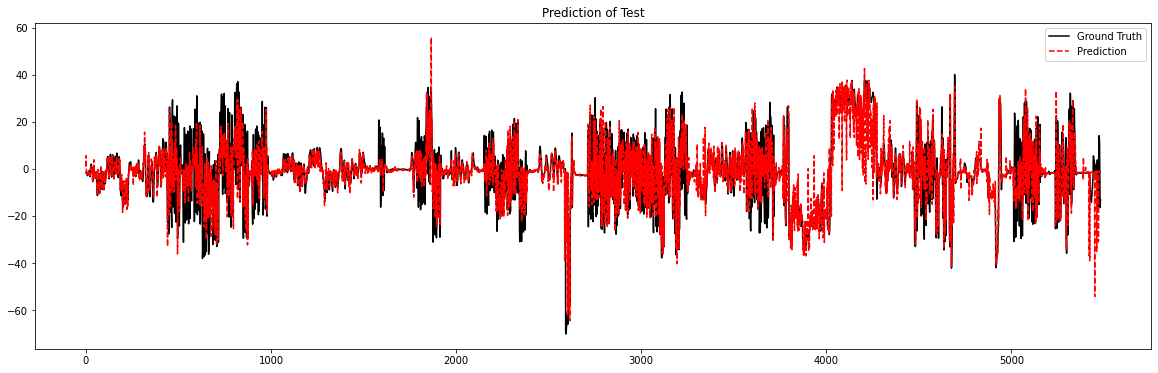

Average error is -0.19 degrees
Root Mean Squared Error is 5.20 degrees
Mean Absolute Error is 5.20 degrees


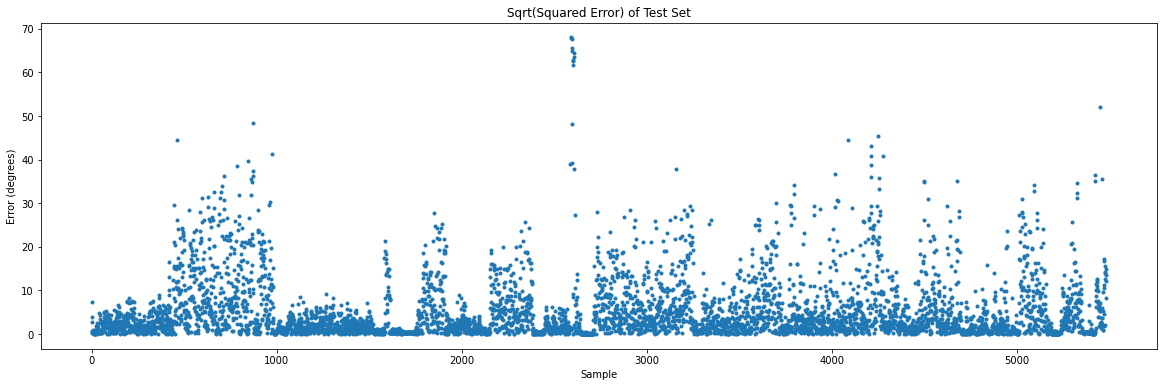

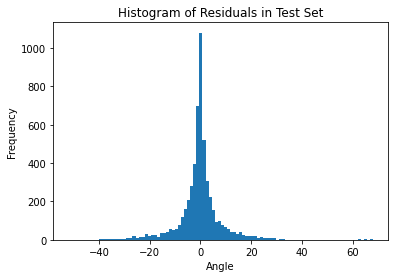

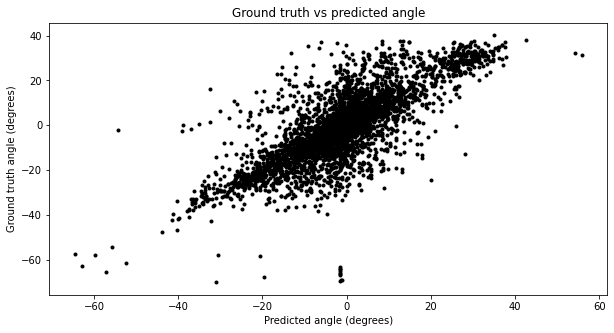

In [28]:
# Redo test set
Xtest = Testset
y_pred = model.predict(Xtest)
#y_pred = sc_y.inverse_transform(y_pred)
y_pred = sc_y.inverse_transform(y_pred)
y_new = Testy

plt.figure(figsize=(20,6))
plt.plot(y_new,'k')
plt.plot(y_pred,'r--')
plt.title('Prediction of Test')
#plt.axis([xmin, xmax, ymin, ymax])
plt.legend(labels=['Ground Truth','Prediction'])
plt.show()

# Squared-root of Squared Error

test_error = (y_pred - y_new)
print('Average error is {:4.2f} degrees'.format(np.sum(test_error)/test_error.shape[0]))
rmse = np.sqrt(test_error**2)
print('Root Mean Squared Error is {:4.2f} degrees'.format(np.sum(rmse)/test_error.shape[0]))
# Mean absolute error
print('Mean Absolute Error is {:4.2f} degrees'.format(np.sum(np.abs(test_error))/test_error.shape[0]))
plt.figure(figsize=(20,6))
plt.plot(rmse,'.')
plt.title('Sqrt(Squared Error) of Test Set')
plt.xlabel('Sample')
plt.ylabel('Error (degrees)')
plt.show()

plt.figure()
plt.hist(test_error,bins=100)
plt.title('Histogram of Residuals in Test Set')
plt.xlabel('Angle')
plt.ylabel('Frequency')
plt.show()

#plot scatterplot of data
plt.figure(figsize=(10,5))
plt.scatter(y_pred,y_new,marker='.',color='black')
plt.xlabel('Predicted angle (degrees)')
plt.ylabel('Ground truth angle (degrees)')
plt.title('Ground truth vs predicted angle')
plt.show()

In [29]:
save_notebookparams = 1
if save_notebookparams:
    pkl_filename = "depthforcemodelparam_cnn3v5.pkl"
    randata = {}
    randata['nsamps']=nsamps
    randata['n80p']=n80p
    randata['rannums']=rannums
    randata['test_set']=test_set
    modelhistory = history.history
    
    
    with open(pkl_filename, 'wb') as file:
        pickle.dump([randata,sc_y,modelhistory], file)
        
    model.save('depthforcemodel_cnn3v5.h5') 